## Asignación 2: Métricas, datos y calibración inteligente de un sensor.

#### Realizado por:
+ Karen Sarat Anaya Verdugo - 2200813
+ Miguel Fernando Becerra - 2201888

#### Problema
Cuantificar cuál es el error de medición del sensor de bajo costo y,
como calibrarlo para que podamos establecer nuevas lecturas que sean mas precisas.

#### 0. Se importan las librerias que se van a usar.

In [180]:
import joblib
import pandas as pd
import numpy as np
from seaborn import load_dataset
import matplotlib.pyplot as plt
from math import dist
from scipy.optimize import curve_fit
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder 
from numpy.core.umath_tests import inner1d

#### 1. Se hace la lectura de los archivos de datos.

In [181]:
data_0= pd.read_excel("DatosFinal (1).xlsx", sheet_name= "Calibrar")
data_1= pd.read_excel("DatosFinal (1).xlsx", sheet_name= "Referencia")

#### 2. Se calculan las diferentes ventanas móviles y sus respectivas distancias.

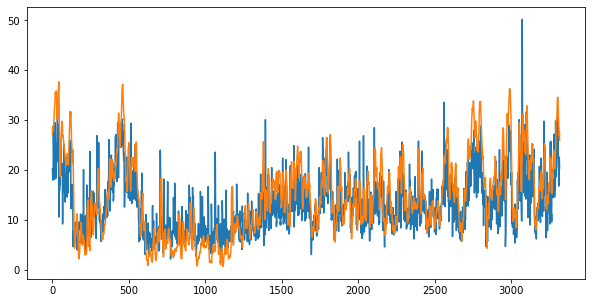

<Figure size 720x360 with 0 Axes>

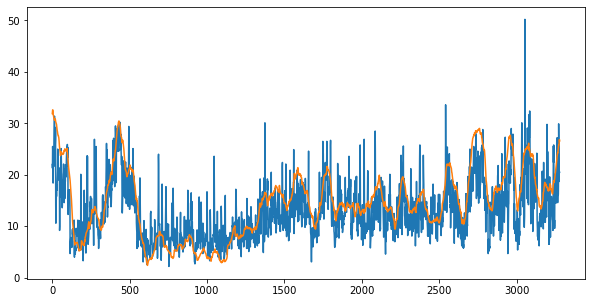

<Figure size 720x360 with 0 Axes>

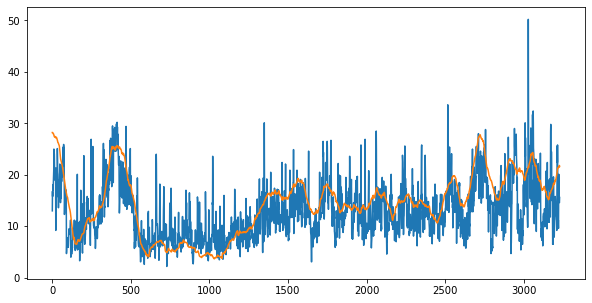

<Figure size 720x360 with 0 Axes>

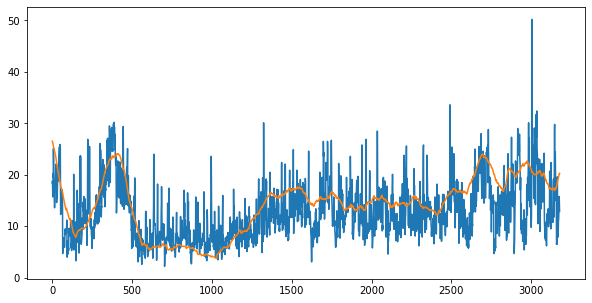

<Figure size 720x360 with 0 Axes>

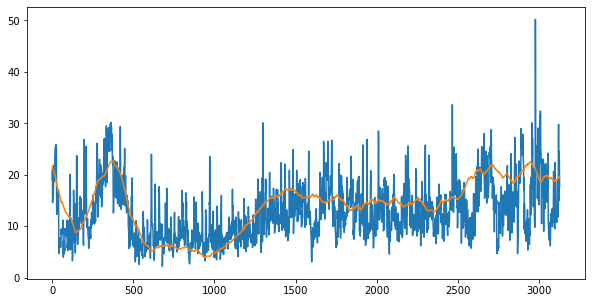

<Figure size 720x360 with 0 Axes>

In [182]:
#Se eligen 5 valores para el tamaño de las ventanas.
ven=[10,50,100,150,200]

#Se crea un lista para luego agregar las distancias para cada ventana.
m=[]

#Se hace un for para calcular y graficar la distancia euclidea para cada valor de la ventana móvil.
for i in ven:
    x=data_0["Promedio"]=data_0["pm25_a"].rolling(i, center=True).mean()
    y=data_1["Promedio"]=data_1["pm25_a"].rolling(i, center=True).mean()
    y1=data_0.dropna()
    x1=data_1.dropna()
    a=np.array(y1["Promedio"])
    b=np.array(x1["Promedio"])
    dist=np.linalg.norm(a-b)
    pri=np.array(x1["pm25_a"])
    m.append(dist)
  
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(1,len(pri)+1,1),pri,"-")
    plt.plot(np.arange(1,len(a)+1,1),a,"-")
    plt.show()
    plt.figure(figsize=(10,5))

In [183]:
#Distancias euclideanas para cada ventana.
print(m)

[246.20216644123684, 190.02532119331835, 171.10075082927165, 158.98643377531016, 150.97245488204885]


#### 3. Se grafican las distancias obtenidas vs los anchos de ventana para elegir la más óptima.

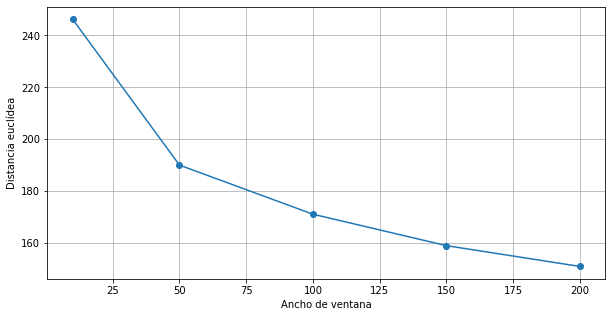

In [184]:
plt.figure(figsize=(10,5))
plt.plot(ven,m,"o-")
plt.xlabel("Ancho de ventana")
plt.ylabel("Distancia euclídea")
plt.grid()
plt.show()

#### 4. Se calculan los promedios móviles para un ancho de ventana de 100.

In [185]:
data_0["Promedio"]=data_0["pm25_a"].rolling(100, center=True).mean().dropna()
data_1["Promedio"]=data_1["pm25_a"].rolling(100, center=True).mean().dropna()

#### 5. Se grafican los promedios móviles de los datos de referencia vs los datos de sensor de bajo costo.

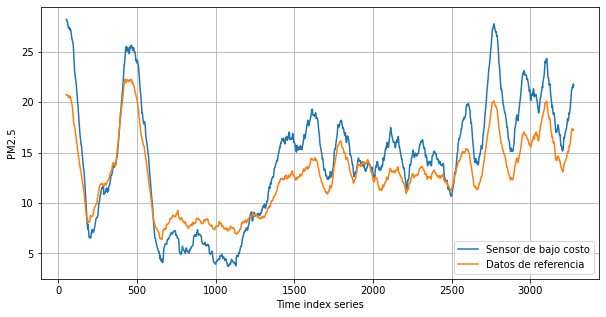

In [186]:
x1=data_0.dropna()
y1=data_1.dropna()
x1=x1["Promedio"]
y1=y1["Promedio"]

plt.figure(figsize=(10,5))
plt.plot(x1,label="Sensor de bajo costo")
plt.plot(y1,label="Datos de referencia")
plt.ylabel(r"PM2.5")
plt.xlabel("Time index series")
plt.legend(loc='best')
plt.grid()
plt.show()

In [187]:
X_c = sm.add_constant(x1) ## Agreguemos una intersección (beta_0) a nuestro modelo
# Tenga en cuenta la diferencia en el orden de los argumentos.
model = sm.OLS(y1, X_c).fit()
predictions = model.predict(X_c) # Se hace las predicciones por el modelo

# Imprime las estadísticas.
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Promedio   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 3.962e+04
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:31:10   Log-Likelihood:                -4538.6
No. Observations:                3227   AIC:                             9081.
Df Residuals:                    3225   BIC:                             9093.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2702      0.046     93.096      0.000       4.180       4.360
Promedio       0.5920      0.003    199.041      0.000       0.586       0.598
==============================================================================
Omnibus:                      402.848   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              594.792
Skew:                           0.916   Prob(JB):                    6.96e-130
Kurtosis:                       4.034   Cond. No.                         40.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Calibración lineal simple de los datos.

In [188]:
lm = linear_model.LinearRegression()
x1=np.array(x1).reshape(-1,1)
model = lm.fit(x1,y1)
predictions = lm.predict(x1)
print(predictions)

[20.97484323 20.97928346 20.97780339 ... 17.1537883  17.18486983
 17.07583777]


In [189]:
lm.score(x1,y1)
print(lm.coef_,lm.intercept_)

[0.59202916] 4.270247018066533


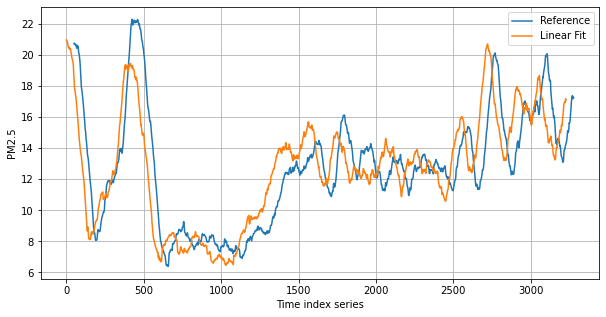

In [190]:
plt.figure(figsize=(10,5))
plt.plot(y1,label="Reference")
plt.plot((x1*lm.coef_+lm.intercept_),label="Linear Fit")
plt.ylabel(r"PM2.5")
plt.xlabel("Time index series")
plt.legend(loc='best')
plt.grid()
plt.show()

#### 6. Se crea un modelo de regresión lineal para ajustar los datos.

In [191]:
X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.99, 
                                                    random_state=42) 
  
# Crea un objeto de regresión lineal. 
reg = linear_model.LinearRegression() 
  
# Entrene el modelo usando los conjuntos de train.
reg.fit(X_train, y_train) 
  
# Coeficientes de regresión 
print('Coefficients: \n', reg.coef_,reg.intercept_)
  
# Puntuación de varianza: 1 significa predicción perfecta. 
print('Variance score: {}'.format(reg.score(X_test, y_test))) 

Coefficients: 
 [0.60072376] 4.090456319764671
Variance score: 0.9239370211269912


#### 7. Se grafican los datos obtenidos en el ajuste y los datos originales.

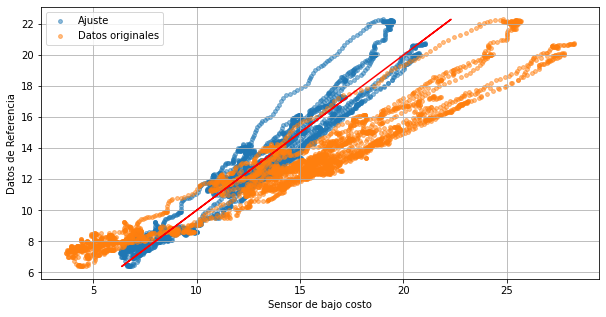

In [192]:
plt.figure(figsize=(10,5))
axe=np.linspace(x1.min()-0.2,x1.max()+0.2,10)
plt.scatter(reg.predict(x1),y1, s = 15, label = 'Ajuste',alpha=0.5)
plt.scatter(x1,y1, s = 15, label = 'Datos originales',alpha=0.5)
plt.plot(y1,y1,'r')
plt.ylabel(r"Datos de Referencia")
plt.xlabel("Sensor de bajo costo")
plt.legend()
plt.grid()
plt.show()

## Calibración de los datos con Random Forest.


In [193]:
train_features,test_features,train_labels,test_labels=train_test_split(x1,y1,test_size=0.1,random_state=0)
# Instancia de modelo con 800 árboles de decisión.
rf=RandomForestRegressor(n_estimators=800,random_state=0)#,max_features="sqrt",criterion="mse"
# Entrene el modelo en datos de train.
rf.fit(train_features,train_labels);
# Utilice el método de predicción del bosque en los datos de prueba.
predictions=rf.predict(test_features)
# Calcula los errores absolutos.
errors=abs(predictions-test_labels)
# Imprime el error absoluto medio (mae).
print('Mean Absolute Error:', np.mean(errors))
# Calcular el error porcentual absoluto medio (MAPE)
mape=100*abs(errors/test_labels)
# Calcular y mostrar la precisión.
accuracy=100-np.mean(mape)
print('Accuracy:', accuracy)

Mean Absolute Error: 0.6414441274924413
Accuracy: 94.89135611787812


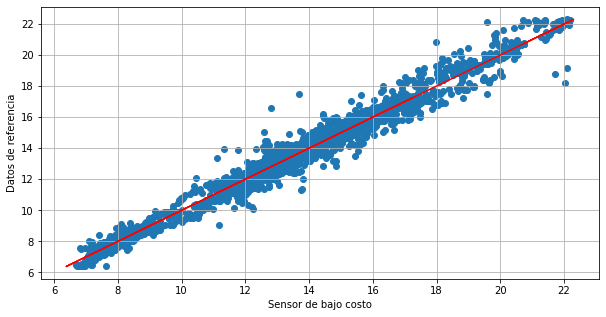

In [194]:
plt.figure(figsize=(10,5))
axe=np.linspace(x1.min()-0.2,x1.max()+0.2,10)
plt.scatter(rf.predict(x1),y1,label='',lw=1,marker='o') 
plt.plot(y1,y1, 'r')
plt.ylabel(r"Datos de referencia")
plt.xlabel("Sensor de bajo costo")
plt.grid()
plt.show()

#### 8. Se grafican los datos de medida sobre los de referencia vs el tiempo.

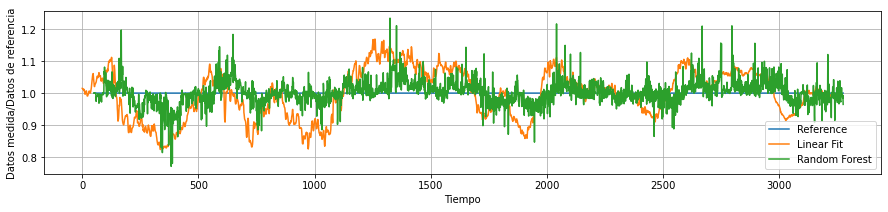

In [195]:
plt.figure(figsize=(15,3))
plt.plot(y1/y1,label="Reference")
plt.plot((x1*reg.coef_+reg.intercept_)[:,0]/y1.values,label="Linear Fit")
plt.plot(rf.predict(x1)/y1,label="Random Forest")
plt.ylabel(r"Datos medida/Datos de referencia")
plt.xlabel("Tiempo")
plt.legend(loc='best')
plt.grid()
plt.show()

#### 9. Se grafican todos los datos y las calibraciones hechas.

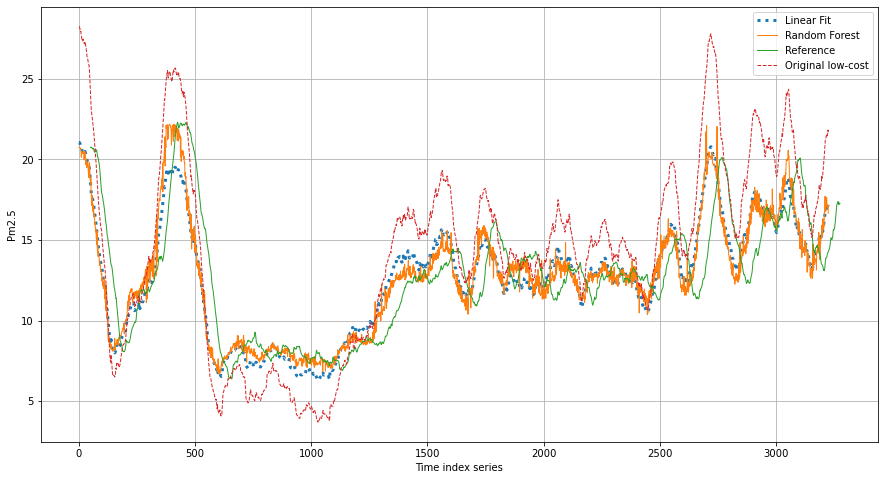

In [196]:
plt.figure(figsize=(15,8))
plt.plot((x1*reg.coef_+reg.intercept_),label="Linear Fit",lw=3,linestyle=':')
plt.plot(rf.predict(x1),label="Random Forest",lw=1,linestyle='-')
plt.plot(y1,label="Reference",lw=1,linestyle='-')
plt.plot(x1,label="Original low-cost",lw=1,linestyle='--')
plt.ylabel(r"Pm2.5")
plt.xlabel("Time index series")
plt.legend(loc='best')
#limxi=100
#plt.xlim(limxi,limxi+20)

#plt.ylim(20,40)
plt.grid()
plt.show()

## Rendimiento de los modelos

#### 10. Se halla el error de los modelos para establecer la mejor calibración.


In [197]:
y_est_L=(x1*reg.coef_+reg.intercept_)[:,0]
y_est_RF=rf.predict(x1)

# Se halla el MAE.
MAE_L=np.mean(np.abs(y_est_L-y1))
MAE_RF=np.mean(np.abs(y_est_RF-y1))
# SE HALLA EL RMSE.
RMSE_L=np.mean((y_est_L-y1)**2)
RMSE_RF=np.mean((y_est_RF-y1)**2)
#SE HALLA EL MRE.
MRE_L=np.mean(np.abs(y_est_L-y1)/y1)
MRE_RF=np.mean(np.abs(y_est_RF-y1)/y1)

#SE HALLA LA ACC.
Acc_L=1.-(np.count_nonzero(np.round(y_est_L-y1)))/len(y1)
Acc_RF=1.-(np.count_nonzero(np.round(y_est_RF-y1)))/len(y1)

In [198]:
table_resume = [["","Intercept","Slope","","","",""],\
                       ["Linear",lm.intercept_,lm.coef_[0],np.round(MAE_L,3),np.round(RMSE_L,3),np.round(MRE_L,3),np.round(Acc_L,3)],\
                    ["RF","-","-",np.round(MAE_RF,3),np.round(RMSE_RF,3),np.round(MRE_RF,3),np.round(Acc_RF,3)]]
pf=pd.DataFrame(table_resume, columns=["Model","c0","c1","MAE","RSME","MRE","Acc"])
print(pf.to_latex())

\begin{tabular}{llllllll}
\toprule
{} &   Model &         c0 &        c1 &    MAE &   RSME &    MRE &    Acc \\
\midrule
0 &         &  Intercept &     Slope &        &        &        &        \\
1 &  Linear &    4.27025 &  0.592029 &  0.783 &  0.981 &  0.062 &  0.354 \\
2 &      RF &          - &         - &  0.326 &  0.236 &  0.025 &  0.792 \\
\bottomrule
\end{tabular}



A continuación, se hace lo mismo pero para los distinto lugares en donde realizaron las mediciones.

# Acualago


#### 1. Se hace la lectura de los archivos de datos.

In [202]:
AcuaCal= pd.read_excel("Acua.Pilar.xlsx", sheet_name= "Cal-Acua")
AcuaRef= pd.read_excel("Acua.Pilar.xlsx", sheet_name= "Ref-Acua")

y=AcuaRef["pm25_a"]
x=AcuaCal["pm25_a"]

#### 2. Se calculan las diferentes ventanas móviles y sus respectivas distancias.

In [203]:
AcuaRef=AcuaRef.drop("Unnamed: 0",axis=1)
AcuaCal=AcuaCal.drop("Unnamed: 0",axis=1)
m=[]
for i in ven:
    AcuaRef["Promedio"] = x.rolling(i, center=True).mean()
    AcuaCal["Promedio"] = y.rolling(i, center=True).mean()
    AcuaRef=AcuaRef["Promedio"].dropna()
    AcuaCal=AcuaCal["Promedio"].dropna()
    a=np.array(AcuaCal)
    b=np.array(AcuaRef)
    dist=np.linalg.norm(a-b)
    m.append(dist)
    print(m)

[424.9088796093879]
[424.9088796093879, 376.82326719812534]
[424.9088796093879, 376.82326719812534, 360.8771474753878]
[424.9088796093879, 376.82326719812534, 360.8771474753878, 351.27911451116614]
[424.9088796093879, 376.82326719812534, 360.8771474753878, 351.27911451116614, 345.0586181267202]


#### 3. Se grafican las distancias obtenidas vs los anchos de ventana para elegir la más óptima.

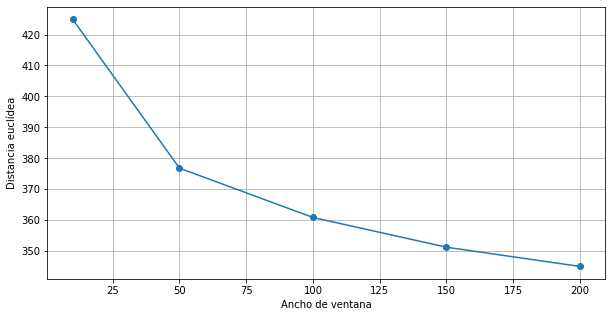

In [204]:
plt.figure(figsize=(10,5))
plt.plot(ven,m,"o-")
plt.xlabel("Ancho de ventana")
plt.ylabel("Distancia euclídea")
plt.grid()
plt.show()

#### 4. Se calculan los promedios móviles para un ancho de ventana de 100.

In [205]:
AcuaRef["Promedio"] = x.rolling(100, center=True).mean().dropna()
AcuaCal["Promedio"] = y.rolling(100, center=True).mean().dropna()
x=AcuaRef["Promedio"]
y=AcuaCal["Promedio"]


#### 5. Se grafican los promedios móviles de los datos de referencia vs los datos de sensor de bajo costo.

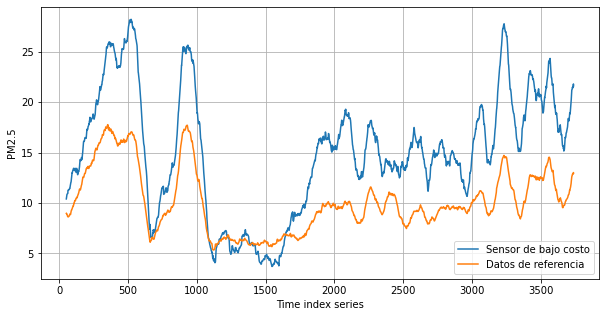

In [206]:
plt.figure(figsize=(10,5))
plt.plot(x,label="Sensor de bajo costo")
plt.plot(y,label="Datos de referencia")
plt.ylabel(r"PM2.5")
plt.xlabel("Time index series")
plt.legend(loc='best')
plt.grid()
plt.show()

In [207]:
X_c = sm.add_constant(x) 
model = sm.OLS(y, X_c).fit()
predictions = model.predict(X_c) 


model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 pm25_a   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                 2.331e+04
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:33:20   Log-Likelihood:                -5783.7
No. Observations:                3691   AIC:                         1.157e+04
Df Residuals:                    3689   BIC:                         1.158e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9283      0.051     57.611      0.000       2.829       3.028
pm25_a         0.4792      0.003    152.668      0.000       0.473       0.485
==============================================================================
Omnibus:                      151.759   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.336
Skew:                           0.515   Prob(JB):                     2.79e-37
Kurtosis:                       2.821   Cond. No.                         43.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Calibración linear simple de los datos.

In [208]:
lm = linear_model.LinearRegression()
x=np.array(x).reshape(-1,1)
model = lm.fit(x,y)
predictions = lm.predict(x)
print(predictions)
lm.score(x,y)
print(lm.coef_,lm.intercept_)

[ 7.91389925  7.96197715  8.00489264 ... 13.35566322 13.38081926
 13.29257344]
[0.47916274] 2.9282832944199013


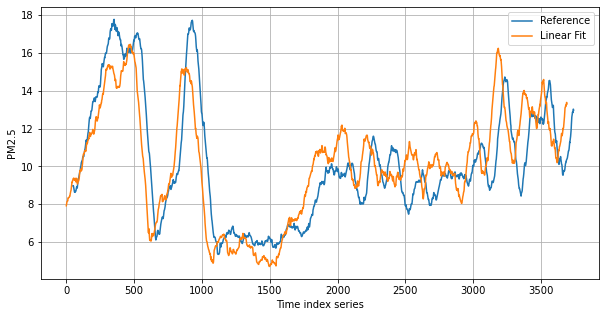

In [209]:
plt.figure(figsize=(10,5))
plt.plot(y,label="Reference")
plt.plot((x*lm.coef_+lm.intercept_),label="Linear Fit")
plt.ylabel(r"PM2.5")
plt.xlabel("Time index series")
plt.legend(loc='best')
plt.grid()
plt.show()

#### 6. Se crea un modelo de regresión lineal para ajustar los datos.

In [210]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, 
                                                    random_state=42) 
  
reg = linear_model.LinearRegression() 
  

reg.fit(X_train, y_train) 
  

print('Coefficients: \n', reg.coef_,reg.intercept_)
  

print('Variance score: {}'.format(reg.score(X_test, y_test))) 

Coefficients: 
 [0.47747851] 2.94084320521861
Variance score: 0.870397534959258


#### 7. Se grafican los datos obtenidos en el ajuste y los datos originales.

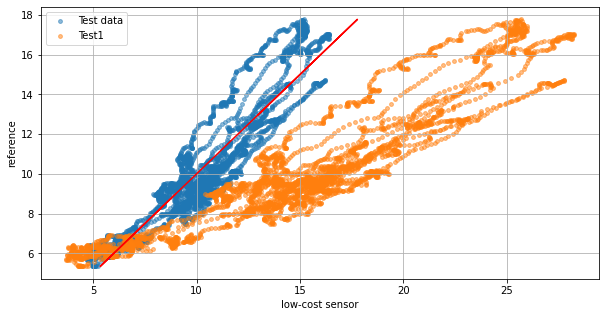

In [211]:
plt.figure(figsize=(10,5))
axe=np.linspace(x.min()-0.2,x.max()+0.2,10)
plt.scatter(reg.predict(x),y, s = 15, label = 'Test data',alpha=0.5)
plt.scatter(x,y, s = 15, label = 'Test1',alpha=0.5)
plt.plot(y,y,'r')
plt.ylabel(r"reference")
plt.xlabel("low-cost sensor")
plt.legend()
plt.grid()#### 7. Se grafican los datos obtenidos en el ajuste y los datos originales.
plt.show()

In [212]:
r=np.arange(0.1,1,0.1)

## Calibración de los datos con Random Forest.

In [213]:

    train_features,test_features,train_labels,test_labels=train_test_split(x,y,test_size=0.6,random_state=0)
# Instancia de modelo con 800 árboles de decisión.
    rf=RandomForestRegressor(n_estimators=800,random_state=0)#,max_features="sqrt",criterion="mse"
# Entrene el modelo en datos de train.
    rf.fit(train_features,train_labels);
# Utilice el método de predicción del bosque en los datos de prueba.
    predictions=rf.predict(test_features)
# Calcula los errores absolutos.
    errors=abs(predictions-test_labels)
# Imprime el error absoluto medio (mae).
    print('Mean Absolute Error:', np.mean(errors))
# Calcular el error porcentual absoluto medio (MAPE)
    mape=100*abs(errors/test_labels)
# Calcular y mostrar la precisión.
    accuracy=100-np.mean(mape)
    print('Accuracy:', accuracy)

Mean Absolute Error: 0.7971477323999419
Accuracy: 92.52457886388726


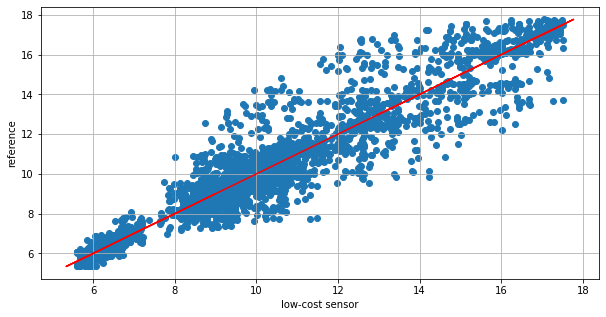

In [214]:
plt.figure(figsize=(10,5))
axe=np.linspace(x.min()-0.2,x.max()+0.2,10)
plt.scatter(rf.predict(x),y,label='',lw=1,marker='o') 
plt.plot(y,y, 'r')
plt.ylabel(r"reference")
plt.xlabel("low-cost sensor")
plt.grid()
plt.show()

#### 8. Se grafican los datos de medida sobre los de referencia vs el tiempo.

In [215]:
plt.figure(figsize=(15,3))
plt.#### 8. Se grafican los datos de medida sobre los de referencia vs el tiempo.plot(y/y,label="Reference")
plt.plot((x*reg.coef_+reg.intercept_)[:,0]/y.values,label="Linear Fit")
plt.plot(rf.predict(x)/y,label="Random Forest")
plt.ylabel(r"Datos de refere")
plt.xlabel("Time")
plt.legend(loc='best')
plt.grid()
plt.show()

SyntaxError: invalid syntax (<ipython-input-215-60ec1309b23e>, line 2)

####  Se grafican todos los datos y las calibraciones hechas.

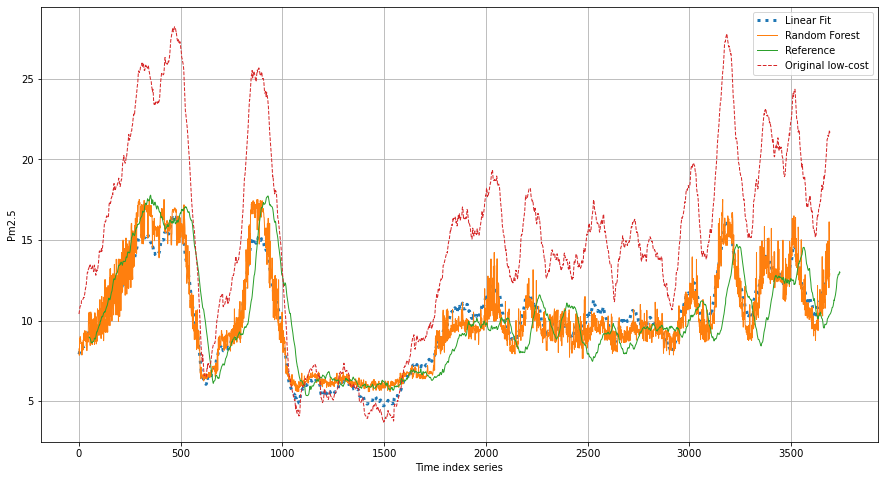

In [216]:
plt.figure(figsize=(15,8))
plt.plot((x*reg.coef_+reg.intercept_),label="Linear Fit",lw=3,linestyle=':')
plt.plot(rf.predict(x),label="Random Forest",lw=1,linestyle='-')
plt.plot(y,label="Reference",lw=1,linestyle='-')
plt.plot(x,label="Original low-cost",lw=1,linestyle='--')
plt.ylabel(r"Pm2.5")
plt.xlabel("Time index series")
plt.legend(loc='best')
#limxi=100
#plt.xlim(limxi,limxi+20)

#plt.ylim(20,40)
plt.grid()
plt.show()

## Rendimiento de los modelos

#### 10. Se halla el error de los modelos para establecer la mejor calibración.


In [217]:
y_est_L=(x*reg.coef_+reg.intercept_)[:,0]
y_est_RF=rf.predict(x)
MAE_L=np.mean(np.abs(y_est_L-y))
MAE_RF=np.mean(np.abs(y_est_RF-y))
RMSE_L=np.mean((y_est_L-y)**2)
RMSE_RF=np.mean((y_est_RF-y)**2)
MRE_L=np.mean(np.abs(y_est_L-y)/y)
MRE_RF=np.mean(np.abs(y_est_RF-y)/y)
Acc_L=1.-(np.count_nonzero(np.round(y_est_L-y)))/len(y)
Acc_RF=1.-(np.count_nonzero(np.round(y_est_RF-y)))/len(y)## Rendimiento de los modelos#### 10. Se halla el error de los modelos para establecer la mejor calibración.


In [218]:
table_resume = [["","Intercept","Slope","","","",""],\
                       ["Linear",lm.intercept_,lm.coef_[0],np.round(MAE_L,3),np.round(RMSE_L,3),np.round(MRE_L,3),np.round(Acc_L,3)],\
                    ["RF","-","-",np.round(MAE_RF,3),np.round(RMSE_RF,3),np.round(MRE_RF,3),np.round(Acc_RF,3)]]
pf=pd.DataFrame(table_resume, columns=["Model","c0","c1","MAE","RSME","MRE","Acc"])
print(pf.to_latex())

\begin{tabular}{llllllll}
\toprule
{} &   Model &         c0 &        c1 &    MAE &   RSME &    MRE &    Acc \\
\midrule
0 &         &  Intercept &     Slope &        &        &        &        \\
1 &  Linear &    2.92828 &  0.479163 &  0.942 &  1.345 &  0.093 &  0.296 \\
2 &      RF &          - &         - &  0.594 &  0.901 &  0.056 &   0.64 \\
\bottomrule
\end{tabular}



# Pilar

#### 10. Se halla el error de los modelos para establecer la mejor calibración.


In [219]:
PilCal = pd.read_excel("Acua.Pilar.xlsx", sheet_name= "Cali-Pilar")
PilRef = pd.read_excel("Acua.Pilar.xlsx", sheet_name= "Ref-Pilar")

x=PilRef["pm25_a"]
y=PilCal["pm25_a"]

#### 2. Se calculan las diferentes ventanas móviles y sus respectivas distancias.

In [220]:
#### 2. Se calculan las diferentes ventanas móviles y sus respectivas distancias.PilRef=PilRef.drop("Unnamed: 0",axis=1)
PilCal=PilCal.drop("Unnamed: 0",axis=1)
m=[]
for i in ven:
    PilRef["Promedio"] = x.rolling(i, center=True).mean()
    PilCal["Promedio"] = y.rolling(i, center=True).mean()
    PilRef=PilRef["Promedio"].dropna()
    PilCal=PilCal["Promedio"].dropna()
    a=np.array(PilCal)
    b=np.array(PilRef)
    dist=np.linalg.norm(a-b)
    m.append(dist)
    print(m)

[264.85002162845734]
[264.85002162845734, 192.82517077162657]
[264.85002162845734, 192.82517077162657, 175.31571429312086]
[264.85002162845734, 192.82517077162657, 175.31571429312086, 159.53704484834026]
[264.85002162845734, 192.82517077162657, 175.31571429312086, 159.53704484834026, 149.96633993174208]


#### 3. Se grafican las distancias obtenidas vs los anchos de ventana para elegir la más óptima.

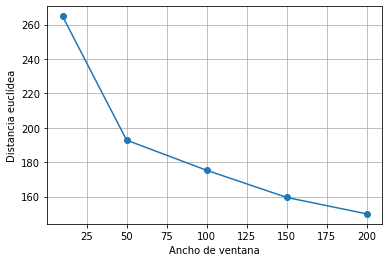

In [221]:
#### 3. Se grafican las distancias obtenidas vs los anchos de ventana para elegir la más óptima.plt.figure(figsize=(10,5))
plt.plot(ven,m,"o-")
plt.xlabel("Ancho de ventana")
plt.ylabel("Distancia euclídea")
plt.grid()
plt.show()

#### 4. Se calculan los promedios móviles para un ancho de ventana de 100.

In [222]:
PilRef["Promedio"] = x.rolling(100, center=True).mean().dropna()
PilCal["Promedio"] = y.rolling(100, center=True).mean().dropna()
x=PilRef["Promedio"]
y=PilCal["Promedio"]


#### 5. Se grafican los promedios móviles de los datos de referencia vs los datos de sensor de bajo costo.

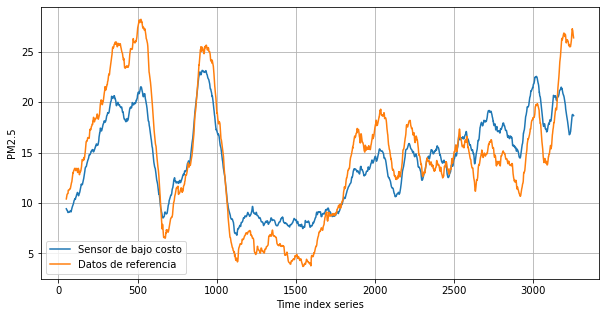

In [223]:
plt.figure(figsize=(10,5))
plt.plot(x,label="Sensor de bajo costo")
plt.plot(y,label="Datos de referencia")
plt.ylabel(r"PM2.5")
plt.xlabel("Time index series")
plt.legend(loc='best')
plt.grid()
plt.show()

In [224]:
X_c = sm.add_constant(x) 
model = sm.OLS(y, X_c).fit()
predictions = model.predict(X_c) 


model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 pm25_a   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                 1.243e+04
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:33:58   Log-Likelihood:                -7890.0
No. Observations:                3206   AIC:                         1.578e+04
Df Residuals:                    3204   BIC:                         1.580e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6687      0.170    -21.608      0.000      -4.002      -3.336
pm25_a         1.2782      0.011    111.509      0.000       1.256       1.301
==============================================================================
Omnibus:                      127.404   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.387
Skew:                          -0.007   Prob(JB):                     9.39e-13
Kurtosis:                       2.356   Cond. No.                         50.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Calibración lineal simple de los datos.

In [225]:
lm = linear_model.LinearRegression()
x=np.array(x).reshape(-1,1)
model = lm.fit(x,y)
predictions = lm.predict(x)
print(predictions)
lm.score(x,y)
print(lm.coef_,lm.intercept_)

[ 8.3856589   8.32302895  8.28724041 ... 20.2099373  20.20099016
 20.18693038]
[1.27816219] -3.6686886984182987


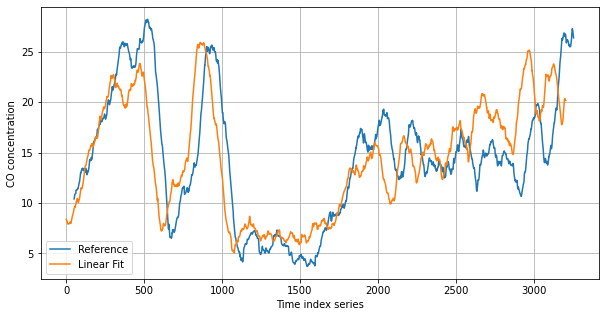

In [226]:
plt.figure(figsize=(10,5))
#plt.plot(data_CO_106["CO_106"],label="Low-cost sensor")
plt.plot(y,label="Reference")
plt.plot((x*lm.coef_+lm.intercept_),label="Linear Fit")
plt.ylabel(r"CO concentration")
plt.xlabel("Time index series")
plt.legend(loc='best')
plt.grid()
plt.show()

#### 6. Se crea un modelo de regresión lineal para ajustar los datos.

In [227]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, 
                                                    random_state=42) 
  
reg = linear_model.LinearRegression() 
  

reg.fit(X_train, y_train) 
  

print('Coefficients: \n', reg.coef_,reg.intercept_)
  

print('Variance score: {}'.format(reg.score(X_test, y_test))) 

Coefficients: 
 [1.28290929] -3.7429404162255704
Variance score: 0.7810980402705461


#### 7. Se grafican los datos obtenidos en el ajuste y los datos originales.

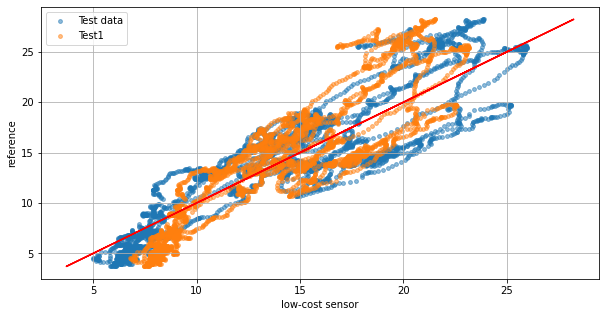

In [228]:
plt.figure(figsize=(10,5))
axe=np.linspace(x.min()-0.2,x.max()+0.2,10)
#plt.scatter(reg.predict(X_train),y_train, s = 15, label = 'Train data',alpha=0.5) 
plt.scatter(reg.predict(x),y, s = 15, label = 'Test data',alpha=0.5)
plt.scatter(x,y, s = 15, label = 'Test1',alpha=0.5)
plt.plot(y,y,'r')
plt.ylabel(r"reference")
plt.xlabel("low-cost sensor")
plt.legend()
plt.grid()
plt.show()

## Calibración de los datos con Random Forest.


In [229]:

    train_features,test_features,train_labels,test_labels=train_test_split(x,y,test_size=0.9,random_state=0)
# Instantiate model with 800 decision trees
    rf=RandomForestRegressor(n_estimators=800,random_state=0)#,max_features="sqrt",criterion="mse"
# Train the model on training data
    rf.fit(train_features,train_labels);
# Use the forest's predict method on the test data
    predictions=rf.predict(test_features)
# Calculate the absolute errors
    errors=abs(predictions-test_labels)
# Print out the mean absolute error (mae)
    print('Mean Absolute Error:', np.mean(errors))
# Calculate mean absolute percentage error (MAPE)
    mape=100*abs(errors/test_labels)
# Calculate and display accuracy
    accuracy=100-np.mean(mape)
    print('Accuracy:', accuracy)

Mean Absolute Error: 2.0355705389917698
Accuracy: 85.5627796851918


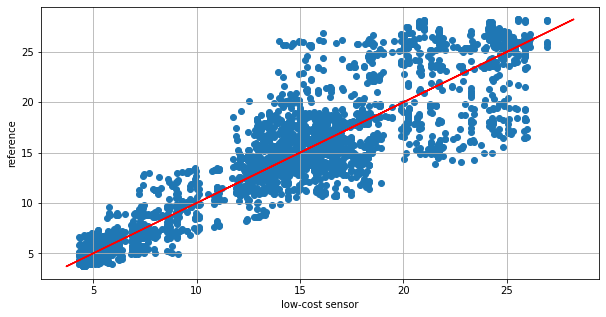

In [230]:
plt.figure(figsize=(10,5))
axe=np.linspace(x.min()-0.2,x.max()+0.2,10)
plt.scatter(rf.predict(x),y,label='',lw=1,marker='o') 
plt.plot(y,y, 'r')
plt.ylabel(r"reference")
plt.xlabel("low-cost sensor")
plt.grid()
plt.show()

#### 8. Se grafican los datos de medida sobre los de referencia vs el tiempo.

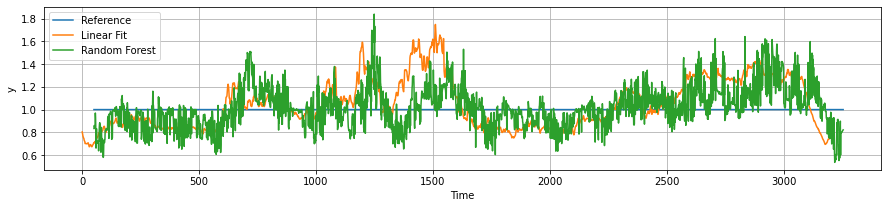

In [231]:
plt.figure(figsize=(15,3))
#plt.plot(data_CO_106["CO_106"],label="Low-cost sensor")
plt.plot(y/y,label="Reference")
plt.plot((x*reg.coef_+reg.intercept_)[:,0]/y.values,label="Linear Fit")
#plt.plot((x1*reg.coef_+reg.intercept_)/y1,label="Linear Fit")
plt.plot(rf.predict(x)/y,label="Random Forest")
plt.ylabel(r"y")
plt.xlabel("Time")
plt.legend(loc='best')
plt.grid()
plt.show()

#### 9. Se grafican todos los datos y las calibraciones hechas.

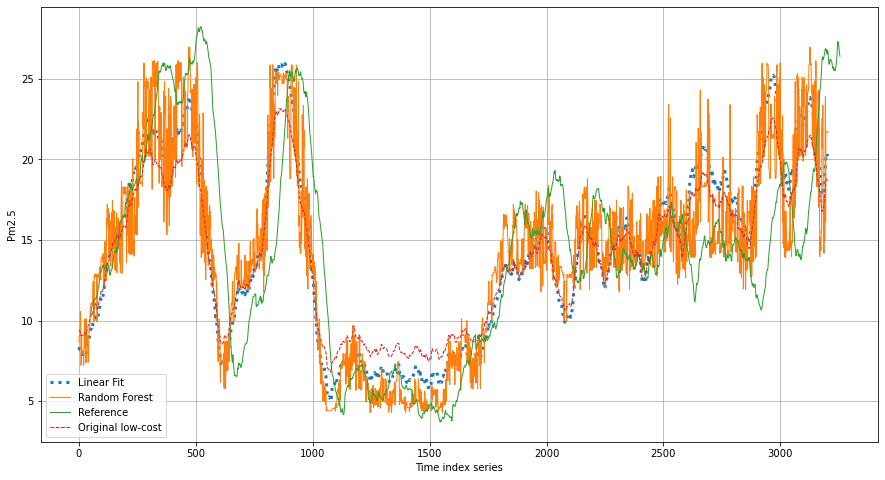

In [232]:
plt.figure(figsize=(15,8))
plt.plot((x*reg.coef_+reg.intercept_),label="Linear Fit",lw=3,linestyle=':')
plt.plot(rf.predict(x),label="Random Forest",lw=1,linestyle='-')
plt.plot(y,label="Reference",lw=1,linestyle='-')
plt.plot(x,label="Original low-cost",lw=1,linestyle='--')
plt.ylabel(r"Pm2.5")
plt.xlabel("Time index series")
plt.legend(loc='best')
#limxi=100
#plt.xlim(limxi,limxi+20)

#plt.ylim(20,40)
plt.grid()
plt.show()

## Rendimiento de los modelos

#### 10. Se halla el error de los modelos para establecer la mejor calibración.


In [233]:
y_est_L=(x*reg.coef_+reg.intercept_)[:,0]
y_est_RF=rf.predict(x)
MAE_L=np.mean(np.abs(y_est_L-y))
MAE_RF=np.mean(np.abs(y_est_RF-y))
RMSE_L=np.mean((y_est_L-y)**2)
RMSE_RF=np.mean((y_est_RF-y)**2)
MRE_L=np.mean(np.abs(y_est_L-y)/y)
MRE_RF=np.mean(np.abs(y_est_RF-y)/y)
Acc_L=1.-(np.count_nonzero(np.round(y_est_L-y)))/len(y)
Acc_RF=1.-(np.count_nonzero(np.round(y_est_RF-y)))/len(y)
table_resume = [["","Intercept","Slope","T-coef","RH-coef","","","",""],\
                       ["Linear",lm.intercept_,lm.coef_[0],"-","-",np.round(MAE_L,3),np.round(RMSE_L,3),np.round(MRE_L,3),np.round(Acc_L,3)],\
                    ["RF","-","-","-","-",np.round(MAE_RF,3),np.round(RMSE_RF,3),np.round(MRE_RF,3),np.round(Acc_RF,3)]]
pd.DataFrame(table_resume, columns=["Model","c0","c1","c21","c22","MAE","RSME","MRE","Acc"])

,Model,c0,c1,c21,c22,MAE,RSME,MRE,Acc
0,,Intercept,Slope,T-coef,RH-coef,,,,
1,Linear,-3.66869,1.27816,-,-,2.357,8.038,0.181,0.117
2,RF,-,-,-,-,1.909,7.569,0.135,0.263


In [234]:
table_resume = [["","Intercept","Slope","","","",""],\
                       ["Linear",lm.intercept_,lm.coef_[0],np.round(MAE_L,3),np.round(RMSE_L,3),np.round(MRE_L,3),np.round(Acc_L,3)],\
                    ["RF","-","-",np.round(MAE_RF,3),np.round(RMSE_RF,3),np.round(MRE_RF,3),np.round(Acc_RF,3)]]
pf=pd.DataFrame(table_resume, columns=["Model","c0","c1","MAE","RSME","MRE","Acc"])
print(pf.to_latex())

\begin{tabular}{llllllll}
\toprule
{} &   Model &         c0 &       c1 &    MAE &   RSME &    MRE &    Acc \\
\midrule
0 &         &  Intercept &    Slope &        &        &        &        \\
1 &  Linear &   -3.66869 &  1.27816 &  2.357 &  8.038 &  0.181 &  0.117 \\
2 &      RF &          - &        - &  1.909 &  7.569 &  0.135 &  0.263 \\
\bottomrule
\end{tabular}



# Girón

#### 1. Se hace la lectura de los archivos de datos.

In [237]:
GirCal = pd.read_excel("GIRON (1).xlsx", sheet_name= "Giron")
GirRef = pd.read_excel("GIRON (1).xlsx", sheet_name= "Ref-Gir")

y=GirCal["pm25_a"]
x=GirRef["pm25_a"]

#### 2. Se calculan las diferentes ventanas móviles y sus respectivas distancias.

In [238]:
m=[]
for i in ven:
    GirRef["Promedio"] = x.rolling(i, center=True).mean()
    GirCal["Promedio"] = y.rolling(i, center=True).mean()
    GirRef=GirRef["Promedio"].dropna()
    GirCal=GirCal["Promedio"].dropna()
    a=np.array(GirCal)
    b=np.array(GirRef)
    dist=np.linalg.norm(a-b)
    m.append(dist)
    print(m)

[342.3725953664017]
[342.3725953664017, 237.3031253244223]
[342.3725953664017, 237.3031253244223, 221.9387000979737]
[342.3725953664017, 237.3031253244223, 221.9387000979737, 211.8189079662511]
[342.3725953664017, 237.3031253244223, 221.9387000979737, 211.8189079662511, 204.04179346841454]


#### 3. Se grafican las distancias obtenidas vs los anchos de ventana para elegir la más óptima.

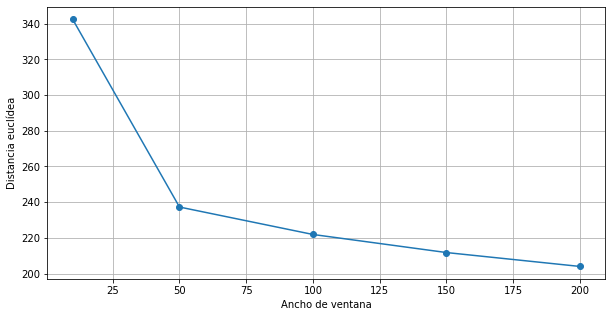

In [239]:
plt.figure(figsize=(10,5))
plt.plot(ven,m,"o-")
plt.xlabel("Ancho de ventana")
plt.ylabel("Distancia euclídea")
plt.grid()
plt.show()

#### 4. Se calculan los promedios móviles para un ancho de ventana de 100.

In [240]:
GirRef["Promedio"] = x.rolling(100, center=True).mean().dropna()
GirCal["Promedio"] = y.rolling(100, center=True).mean().dropna()
x=GirRef["Promedio"]
y=GirCal["Promedio"]


#### 5. Se grafican los promedios móviles de los datos de referencia vs los datos de sensor de bajo costo.

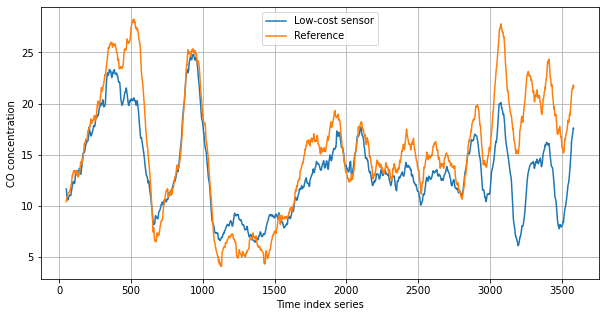

In [241]:
plt.figure(figsize=(10,5))
plt.plot(x,label="Low-cost sensor")
plt.plot(y,label="Reference")
plt.ylabel(r"CO concentration")
plt.xlabel("Time index series")
plt.legend(loc='best')
plt.grid()
plt.show()

In [242]:
X_c = sm.add_constant(x) 
model = sm.OLS(y, X_c).fit()
predictions = model.predict(X_c) 


model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 pm25_a   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     9338.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:35:04   Log-Likelihood:                -8918.1
No. Observations:                3534   AIC:                         1.784e+04
Df Residuals:                    3532   BIC:                         1.785e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1178      0.169     -0.697      0.486      -0.450       0.214
pm25_a         1.1645      0.012     96.632      0.000       1.141       1.188
==============================================================================
Omnibus:                      533.633   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              804.400
Skew:                           1.098   Prob(JB):                    2.12e-175
Kurtosis:                       3.800   Cond. No.                         47.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Calibración lineal simple de los datos.

In [243]:
lm = linear_model.LinearRegression()
x=np.array(x).reshape(-1,1)
model = lm.fit(x,y)
predictions = lm.predict(x)
print(predictions)
lm.score(x,y)
print(lm.coef_,lm.intercept_)

[13.45260082 13.30703283 12.90526517 ... 20.35834624 20.40376345
 20.29196724]
[1.16454392] -0.11782944198705358


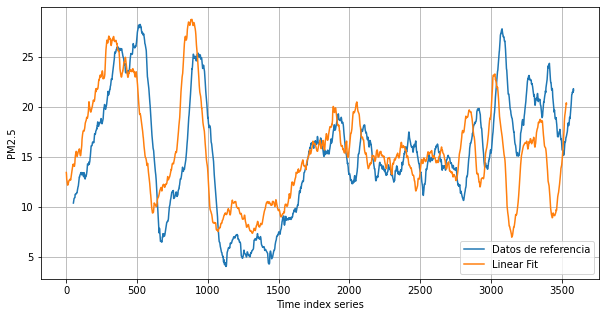

In [244]:
plt.figure(figsize=(10,5))
plt.plot(y,label="Datos de referencia")
plt.plot((x*lm.coef_+lm.intercept_),label="Linear Fit")
plt.ylabel(r"PM2.5")
plt.xlabel("Time index series")
plt.legend(loc='best')
plt.grid()
plt.show()

#### 6. Se crea un modelo de regresión lineal para ajustar los datos.

In [245]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, 
                                                    random_state=42) 
  
reg = linear_model.LinearRegression() 
  

reg.fit(X_train, y_train) 
  

print('Coefficients: \n', reg.coef_,reg.intercept_)
  

print('Variance score: {}'.format(reg.score(X_test, y_test))) 

Coefficients: 
 [1.16296957] -0.0701506286416329
Variance score: 0.7579883352089414


#### 7. Se grafican los datos obtenidos en el ajuste y los datos originales.

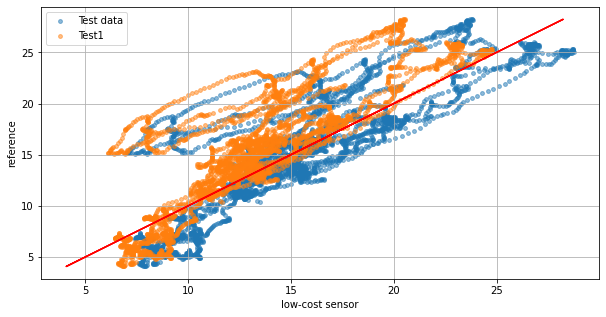

In [246]:
plt.figure(figsize=(10,5))
axe=np.linspace(x.min()-0.2,x.max()+0.2,10)
#plt.scatter(reg.predict(X_train),y_train, s = 15, label = 'Train data',alpha=0.5) 
plt.scatter(reg.predict(x),y, s = 15, label = 'Test data',alpha=0.5)
plt.scatter(x,y, s = 15, label = 'Test1',alpha=0.5)
plt.plot(y,y,'r')
plt.ylabel(r"reference")
plt.xlabel("low-cost sensor")
plt.legend()
plt.grid()
plt.show()

## Calibración de los datos con Random Forest.


In [247]:

    train_features,test_features,train_labels,test_labels=train_test_split(x,y,test_size=0.1,random_state=0)
# Instantiate model with 1000 decision trees
    rf=RandomForestRegressor(n_estimators=800,random_state=0)#,max_features="sqrt",criterion="mse"
# Train the model on training data
    rf.fit(train_features,train_labels);
# Use the forest's predict method on the test data
    predictions=rf.predict(test_features)
# Calculate the absolute errors
    errors=abs(predictions-test_labels)
# Print out the mean absolute error (mae)
    print('Mean Absolute Error:', np.mean(errors))
# Calculate mean absolute percentage error (MAPE)
    mape=100*abs(errors/test_labels)
# Calculate and display accuracy
    accuracy=100-np.mean(mape)
    print('Accuracy:', accuracy)

Mean Absolute Error: 2.3909616627771126
Accuracy: 82.04528795233281


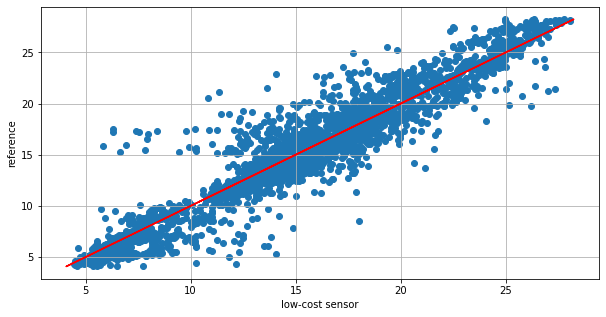

In [248]:
plt.figure(figsize=(10,5))
axe=np.linspace(x.min()-0.2,x.max()+0.2,10)
plt.scatter(rf.predict(x),y,label='',lw=1,marker='o') 
plt.plot(y,y, 'r')
plt.ylabel(r"reference")
plt.xlabel("low-cost sensor")
plt.grid()
plt.show()

#### 8. Se grafican los datos de medida sobre los de referencia vs el tiempo.

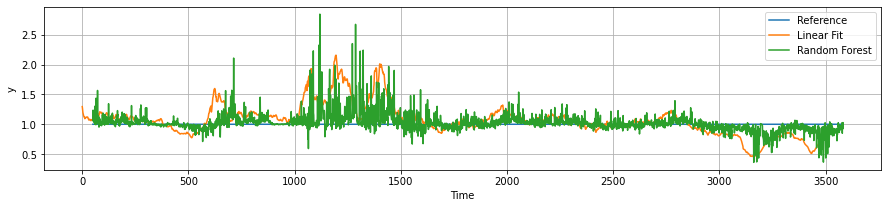

In [249]:
plt.figure(figsize=(15,3))

plt.plot(y/y,label="Reference")
plt.plot((x*reg.coef_+reg.intercept_)[:,0]/y.values,label="Linear Fit")

plt.plot(rf.predict(x)/y,label="Random Forest")
plt.ylabel(r"y")
plt.xlabel("Time")
plt.legend(loc='best')
plt.grid()
plt.show()

#### 9. Se grafican todos los datos y las calibraciones hechas.

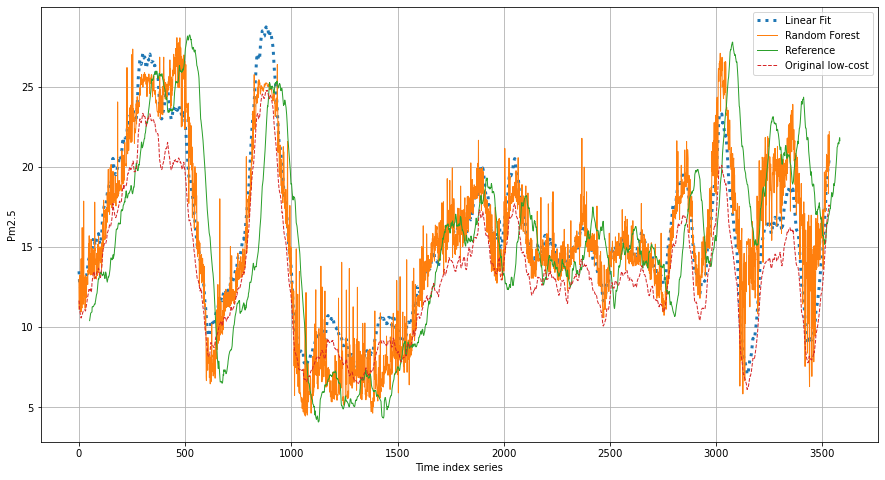

In [250]:
plt.figure(figsize=(15,8))
plt.plot((x*reg.coef_+reg.intercept_),label="Linear Fit",lw=3,linestyle=':')
plt.plot(rf.predict(x),label="Random Forest",lw=1,linestyle='-')
plt.plot(y,label="Reference",lw=1,linestyle='-')
plt.plot(x,label="Original low-cost",lw=1,linestyle='--')
plt.ylabel(r"Pm2.5")
plt.xlabel("Time index series")
plt.legend(loc='best')
#limxi=100
#plt.xlim(limxi,limxi+20)

#plt.ylim(20,40)
plt.grid()
plt.show()

## Rendimiento de los modelos

#### 10. Se halla el error de los modelos para establecer la mejor calibración.


In [251]:
y_est_L=(x*reg.coef_+reg.intercept_)[:,0]
y_est_RF=rf.predict(x)
MAE_L=np.mean(np.abs(y_est_L-y))
MAE_RF=np.mean(np.abs(y_est_RF-y))
RMSE_L=np.mean((y_est_L-y)**2)
RMSE_RF=np.mean((y_est_RF-y)**2)
MRE_L=np.mean(np.abs(y_est_L-y)/y)
MRE_RF=np.mean(np.abs(y_est_RF-y)/y)
Acc_L=1.-(np.count_nonzero(np.round(y_est_L-y)))/len(y)
Acc_RF=1.-(np.count_nonzero(np.round(y_est_RF-y)))/len(y)
table_resume = [["","Intercept","Slope","T-coef","RH-coef","","","",""],\
                       ["Linear",lm.intercept_,lm.coef_[0],"-","-",np.round(MAE_L,3),np.round(RMSE_L,3),np.round(MRE_L,3),np.round(Acc_L,3)],\
                    ["RF","-","-","-","-",np.round(MAE_RF,3),np.round(RMSE_RF,3),np.round(MRE_RF,3),np.round(Acc_RF,3)]]
pd.DataFrame(table_resume, columns=["Model","c0","c1","c21","c22","MAE","RSME","MRE","Acc"])

,Model,c0,c1,c21,c22,MAE,RSME,MRE,Acc
0,,Intercept,Slope,T-coef,RH-coef,,,,
1,Linear,-0.117829,1.16454,-,-,2.327,9.109,0.184,0.13
2,RF,-,-,-,-,1.104,2.937,0.084,0.414


In [ ]:
table_resume = [["","Intercept","Slope","","","",""],\
                       ["Linear",lm.intercept_,lm.coef_[0],np.round(MAE_L,3),np.round(RMSE_L,3),np.round(MRE_L,3),np.round(Acc_L,3)],\
                    ["RF","-","-",np.round(MAE_RF,3),np.round(RMSE_RF,3),np.round(MRE_RF,3),np.round(Acc_RF,3)]]
pf=pd.DataFrame(table_resume, columns=["Model","c0","c1","MAE","RSME","MRE","Acc"])
print(pf.to_latex())

# Caldas

#### 1. Se hace la lectura de los archivos de datos.

In [252]:
CalCal = pd.read_excel("GIRON (1).xlsx", sheet_name= "Caldas")
CalRef = pd.read_excel("GIRON (1).xlsx", sheet_name= "Ref-Cal")

y=CalCal["pm25_a"]
x=CalRef["pm25_a"]

#### 2. Se calculan las diferentes ventanas móviles y sus respectivas distancias.

In [253]:
m=[]
for i in ven:
    CalRef["Promedio"] = x.rolling(i, center=True).mean()
    CalCal["Promedio"] = y.rolling(i, center=True).mean()
    CalRef=CalRef["Promedio"].dropna()
    CalCal=CalCal["Promedio"].dropna()
    a=np.array(CalCal)
    b=np.array(CalRef)
    dist=np.linalg.norm(a-b)
    m.append(dist)
    print(m)

[355.7072418258307]
[355.7072418258307, 308.61583350043117]
[355.7072418258307, 308.61583350043117, 295.3410410258548]
[355.7072418258307, 308.61583350043117, 295.3410410258548, 287.13252820109864]
[355.7072418258307, 308.61583350043117, 295.3410410258548, 287.13252820109864, 280.62653136625727]


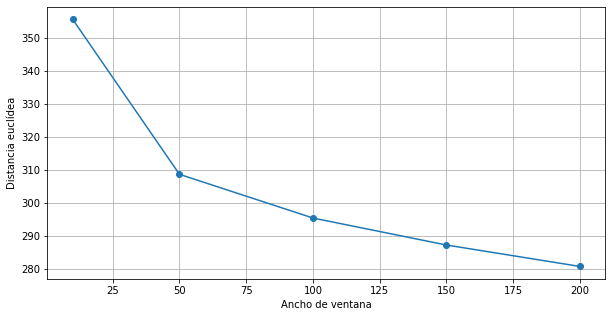

In [254]:
plt.figure(figsize=(10,5))
plt.plot(ven,m,"o-")
plt.xlabel("Ancho de ventana")
plt.ylabel("Distancia euclídea")
plt.grid()
plt.show()

#### 4. Se calculan los promedios móviles para un ancho de ventana de 100.

In [255]:
CalRef["Promedio"] = x.rolling(100, center=True).mean().dropna()
CalCal["Promedio"] = y.rolling(100, center=True).mean().dropna()
x=CalRef["Promedio"]
y=CalCal["Promedio"]

#### 5. Se grafican los promedios móviles de los datos de referencia vs los datos de sensor de bajo costo.

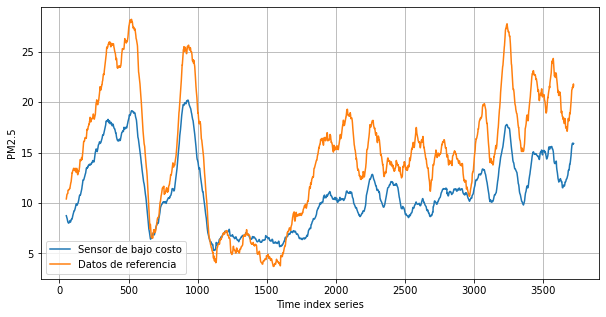

In [256]:
plt.figure(figsize=(10,5))
plt.plot(x,label="Sensor de bajo costo")
plt.plot(y,label="Datos de referencia")
plt.ylabel(r"PM2.5")
plt.xlabel("Time index series")
plt.legend(loc='best')
plt.grid()
plt.show()

In [257]:
X_c = sm.add_constant(x) 
model = sm.OLS(y, X_c).fit()
predictions = model.predict(X_c) 


model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 pm25_a   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                 3.439e+04
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:35:46   Log-Likelihood:                -7570.7
No. Observations:                3671   AIC:                         1.515e+04
Df Residuals:                    3669   BIC:                         1.516e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9771      0.102    -29.171      0.000      -3.177      -2.777
pm25_a         1.6175      0.009    185.452      0.000       1.600       1.635
==============================================================================
Omnibus:                      210.893   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.092
Skew:                           0.062   Prob(JB):                     2.46e-18
Kurtosis:                       2.282   Cond. No.                         38.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Calibración lineal simple de los datos.

In [258]:
lm = linear_model.LinearRegression()
x=np.array(x).reshape(-1,1)
model = lm.fit(x,y)
predictions = lm.predict(x)
print(predictions)
lm.score(x,y)
print(lm.coef_,lm.intercept_)

[11.1600105  11.10177968 10.99664069 ... 22.7625019  22.79161731
 22.74956172]
[1.61752285] -2.9771392112515507


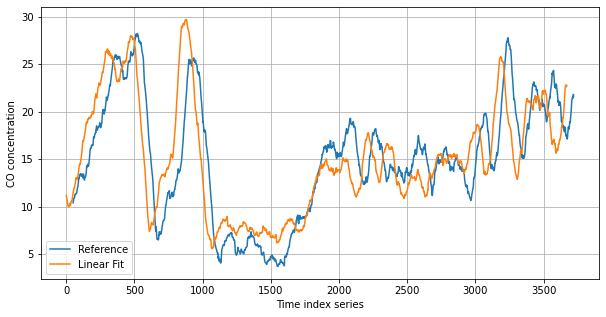

In [259]:
plt.figure(figsize=(10,5))
#plt.plot(data_CO_106["CO_106"],label="Low-cost sensor")
plt.plot(y,label="Reference")
plt.plot((x*lm.coef_+lm.intercept_),label="Linear Fit")
plt.ylabel(r"CO concentration")
plt.xlabel("Time index series")
plt.legend(loc='best')
plt.grid()
plt.show()

#### 6. Se crea un modelo de regresión lineal para ajustar los datos.

In [260]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, 
                                                    random_state=42) 
  
reg = linear_model.LinearRegression() 
  

reg.fit(X_train, y_train) 
  

print('Coefficients: \n', reg.coef_,reg.intercept_)
  

print('Variance score: {}'.format(reg.score(X_test, y_test))) 

Coefficients: 
 [1.61935826] -2.990659923997381
Variance score: 0.9105268161445446


#### 7. Se grafican los datos obtenidos en el ajuste y los datos originales.

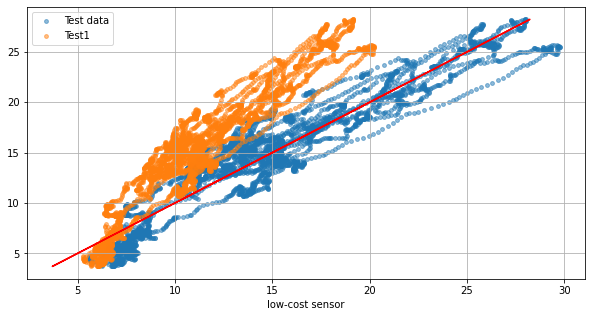

In [261]:
plt.figure(figsize=(10,5))
axe=np.linspace(x.min()-0.2,x.max()+0.2,10)
#plt.scatter(reg.predict(X_train),y_train, s = 15, label = 'Train data',alpha=0.5) 
plt.scatter(reg.predict(x),y, s = 15, label = 'Test data',alpha=0.5)
plt.scatter(x,y, s = 15, label = 'Test1',alpha=0.5)
plt.plot(y,y,'r')
plt.xlabel("low-cost sensor")
plt.legend()
plt.grid()
plt.show()

## Calibración de los datos con Random Forest.


In [262]:

    train_features,test_features,train_labels,test_labels=train_test_split(x,y,test_size=0.1,random_state=0)
# Instantiate model with 800 decision trees
    rf=RandomForestRegressor(n_estimators=800,random_state=0)#,max_features="sqrt",criterion="mse"
# Train the model on training data
    rf.fit(train_features,train_labels);
# Use the forest's predict method on the test data
    predictions=rf.predict(test_features)
# Calculate the absolute errors
    errors=abs(predictions-test_labels)
# Print out the mean absolute error (mae)
    print('Mean Absolute Error:', np.mean(errors))
# Calculate mean absolute percentage error (MAPE)
    mape=100*abs(errors/test_labels)
# Calculate and display accuracy
    accuracy=100-np.mean(mape)
    print('Accuracy:', accuracy)

Mean Absolute Error: 1.2554322020217104
Accuracy: 89.94338976094807


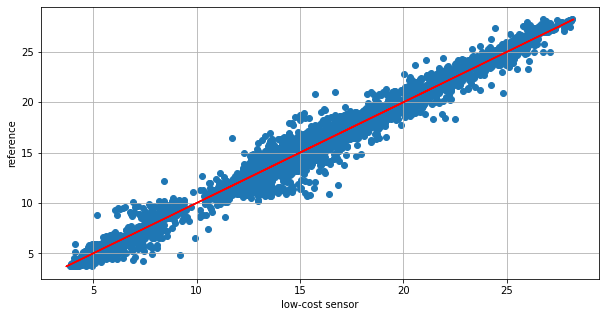

In [263]:
plt.figure(figsize=(10,5))
axe=np.linspace(x.min()-0.2,x.max()+0.2,10)
plt.scatter(rf.predict(x),y,label='',lw=1,marker='o') 
plt.plot(y,y, 'r')
plt.ylabel(r"reference")
plt.xlabel("low-cost sensor")
plt.grid()
plt.show()

#### 8. Se grafican los datos de medida sobre los de referencia vs el tiempo.

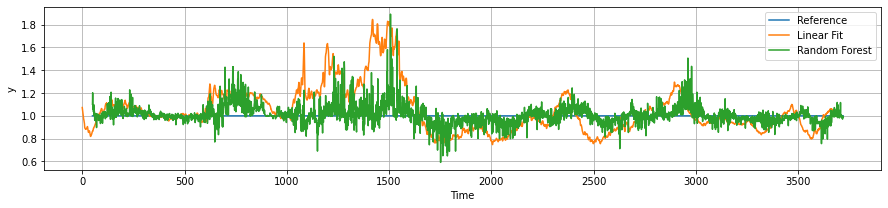

In [264]:
plt.figure(figsize=(15,3))
#plt.plot(data_CO_106["CO_106"],label="Low-cost sensor")
plt.plot(y/y,label="Reference")
plt.plot((x*reg.coef_+reg.intercept_)[:,0]/y.values,label="Linear Fit")
#plt.plot((x1*reg.coef_+reg.intercept_)/y1,label="Linear Fit")
plt.plot(rf.predict(x)/y,label="Random Forest")
plt.ylabel(r"y")
plt.xlabel("Time")
plt.legend(loc='best')
plt.grid()
plt.show()

#### 9. Se grafican todos los datos y las calibraciones hechas.

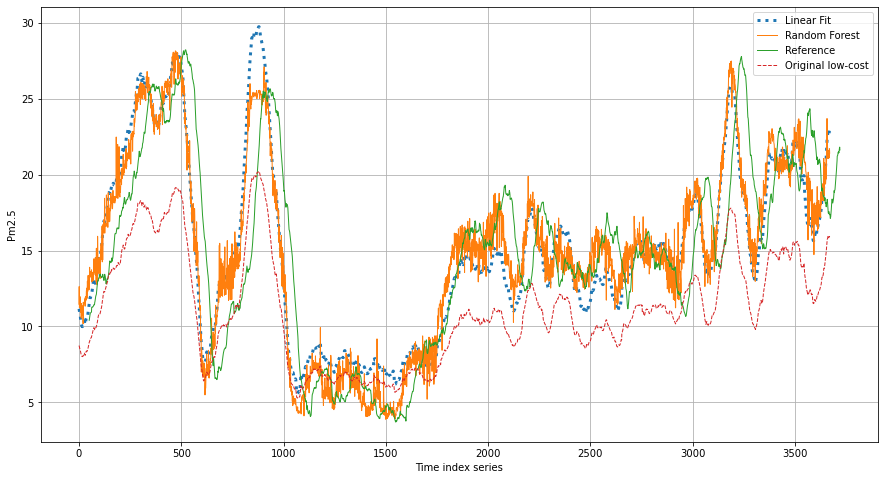

In [265]:
plt.figure(figsize=(15,8))
plt.plot((x*reg.coef_+reg.intercept_),label="Linear Fit",lw=3,linestyle=':')
plt.plot(rf.predict(x),label="Random Forest",lw=1,linestyle='-')
plt.plot(y,label="Reference",lw=1,linestyle='-')
plt.plot(x,label="Original low-cost",lw=1,linestyle='--')
plt.ylabel(r"Pm2.5")
plt.xlabel("Time index series")
plt.legend(loc='best')
#limxi=100
#plt.xlim(limxi,limxi+20)

#plt.ylim(20,40)
plt.grid()
plt.show()

## Rendimiento de los modelos

## Rendimiento de los modelos

In [266]:
y_est_L=(x*reg.coef_+reg.intercept_)[:,0]
y_est_RF=rf.predict(x)
MAE_L=np.mean(np.abs(y_est_L-y))
MAE_RF=np.mean(np.abs(y_est_RF-y))
RMSE_L=np.mean((y_est_L-y)**2)
RMSE_RF=np.mean((y_est_RF-y)**2)
MRE_L=np.mean(np.abs(y_est_L-y)/y)
MRE_RF=np.mean(np.abs(y_est_RF-y)/y)
Acc_L=1.-(np.count_nonzero(np.round(y_est_L-y)))/len(y)
Acc_RF=1.-(np.count_nonzero(np.round(y_est_RF-y)))/len(y)
table_resume = [["","Intercept","Slope","T-coef","RH-coef","","","",""],\
                       ["Linear",lm.intercept_,lm.coef_[0],"-","-",np.round(MAE_L,3),np.round(RMSE_L,3),np.round(MRE_L,3),np.round(Acc_L,3)],\
                    ["RF","-","-","-","-",np.round(MAE_RF,3),np.round(RMSE_RF,3),np.round(MRE_RF,3),np.round(Acc_RF,3)]]
pd.DataFrame(table_resume, columns=["Model","c0","c1","c21","c22","MAE","RSME","MRE","Acc"])

,Model,c0,c1,c21,c22,MAE,RSME,MRE,Acc
0,,Intercept,Slope,T-coef,RH-coef,,,,
1,Linear,-2.97714,1.61752,-,-,1.588,3.621,0.143,0.181
2,RF,-,-,-,-,0.681,0.935,0.054,0.524


In [ ]:
table_resume = [["","Intercept","Slope","","","",""],\
                       ["Linear",lm.intercept_,lm.coef_[0],np.round(MAE_L,3),np.round(RMSE_L,3),np.round(MRE_L,3),np.round(Acc_L,3)],\
                    ["RF","-","-",np.round(MAE_RF,3),np.round(RMSE_RF,3),np.round(MRE_RF,3),np.round(Acc_RF,3)]]
pf=pd.DataFrame(table_resume, columns=["Model","c0","c1","MAE","RSME","MRE","Acc"])
print(pf.to_latex())